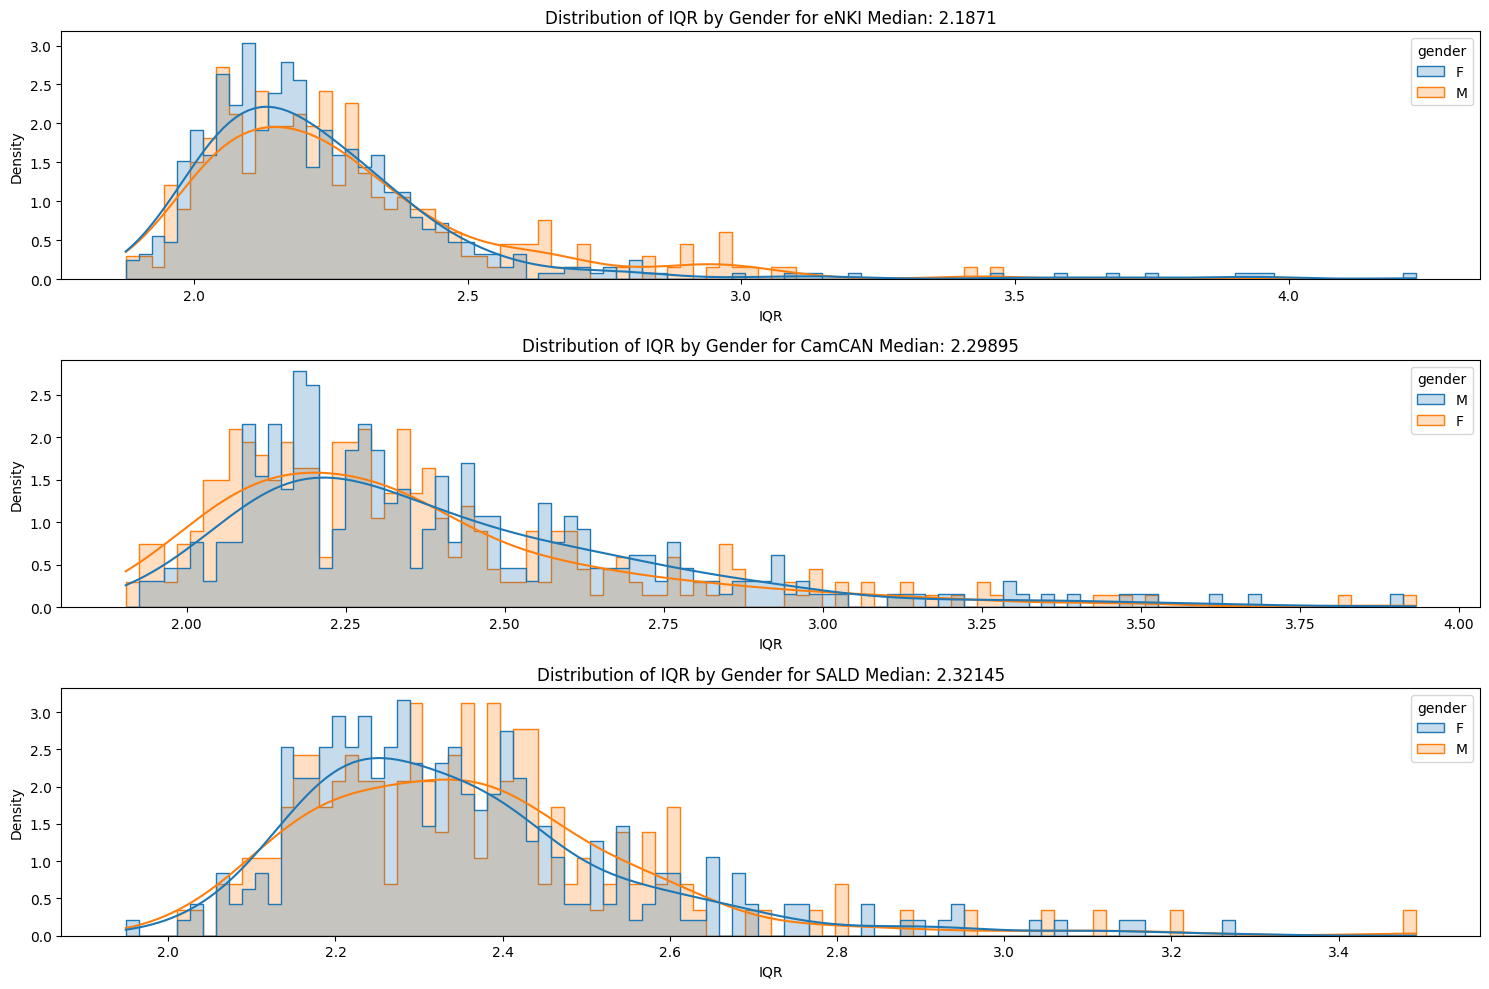

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
import scipy.stats as stats

sites = ["eNKI", "CamCAN","SALD"]

data_dir = "../../data/"

# %%
# Main loop
plt.figure(figsize=(15, 10))
for i, site in enumerate(sites):
    Y_data = pd.read_csv(data_dir + "Y_" + site + ".csv")
    qc_data = pd.read_csv(data_dir+"QC_"+site+".csv")
    qc_data.rename(columns={"SubjectID": "subject"}, inplace=True)

    # For the naming exeptions
    if site == "eNKI":
        qc_data = qc_data[qc_data["Session"] == "ses-BAS1"]
    if site == "SALD":
        qc_data['subject'] = qc_data['subject'].str.replace('sub-', '')
        qc_data['subject'] = pd.to_numeric(qc_data['subject'])

    Y_data = pd.merge(Y_data, qc_data[['subject', 'IQR']],
                      on='subject', how='left')

    # Remove those subject without QC data
    Y_data = Y_data.dropna()

    # Visualizing the distribution by gender
    plt.subplot(3, 1, i+1)

    sbn.histplot(Y_data, x='IQR', hue='gender', kde=True, element='step', stat="density", common_norm=False, bins=100)
    plt.title(f'Distribution of IQR by Gender for '+site+" Median: "+ str(Y_data["IQR"].median()))
    plt.xlabel('IQR')
    plt.ylabel('Density')

plt.tight_layout()
plt.show()

In [25]:

# Function to analyze differences by gender
def analyze_gender_differences(df):
    results = {}
    
    for col in ['IQR']:
        print(f"\nAnalyzing {col}:")
        male_data = df[df['gender'] == 'M'][col]
        female_data = df[df['gender'] == 'F'][col]
        
        # Step 1: Check Normality with Shapiro-Wilk Test
        male_normality_p = stats.shapiro(male_data)[1]
        female_normality_p = stats.shapiro(female_data)[1]
        normality = (male_normality_p > 0.05) and (female_normality_p > 0.05)
        print(f"  Normality - Male p-value: {male_normality_p}, Female p-value: {female_normality_p}")
        
        # Step 2: Check Homogeneity of Variances with Levene's Test
        levene_p = stats.levene(male_data, female_data)[1]
        equal_variance = levene_p > 0.05
        print(f"  Levene's test for equal variances - p-value: {levene_p}")
        
        # Step 3: Choose and Perform the Appropriate Test
        if normality:
            if equal_variance:
                # Use T-test
                stat, p_value = stats.ttest_ind(male_data, female_data, equal_var=True)
                test_used = "T-test (equal variances)"
            else:
                # Use Welch's T-test
                stat, p_value = stats.ttest_ind(male_data, female_data, equal_var=False)
                test_used = "Welch's T-test (unequal variances)"
        else:
            # Use Mann-Whitney U Test
            stat, p_value = stats.mannwhitneyu(male_data, female_data, alternative='two-sided')
            test_used = "Mann-Whitney U Test (non-normal distribution)"
        
        # Step 4: Interpret the Results
        significant = p_value < 0.05
        results[col] = {
            'test_used': test_used,
            'p_value': p_value,
            'significant': significant
        }
        print(f"  Test used: {test_used}, p-value: {p_value}, Significant: {significant}")
    
    return results

for i, site in enumerate(sites):
    print(site)
    Y_data = pd.read_csv(root_dir + "Y_" + site + ".csv")
    qc_data = pd.read_csv(qc_dir+site+"_cat12.8.1_rois_thalamus.csv")
    qc_data.rename(columns={"SubjectID": "subject"}, inplace=True)

    # For the naming exeptions
    if site == "eNKI":
        qc_data = qc_data[qc_data["Session"] == "ses-BAS1"]
    if site == "SALD":
        qc_data['subject'] = qc_data['subject'].str.replace('sub-', '')
        qc_data['subject'] = pd.to_numeric(qc_data['subject'])

    Y_data = pd.merge(Y_data, qc_data[['subject', 'IQR']],
                      on='subject', how='left')

    # Remove those subject without QC data
    Y_data = Y_data.dropna()
    # Run the analysis
    results = analyze_gender_differences(Y_data)

    # # Print final summary
    # print("\nFinal Results Summary:")
    # for run, res in results.items():
        # print(f"{run}:")
        # print(f"  Test used: {res['test_used']}")
        # print(f"  p-value: {res['p_value']}")
        # print(f"  Statistically Significant: {res['significant']}")


eNKI

Analyzing IQR:
  Normality - Male p-value: 9.299185092749226e-15, Female p-value: 2.8030498995018847e-29
  Levene's test for equal variances - p-value: 0.1993253154089208
  Test used: Mann-Whitney U Test (non-normal distribution), p-value: 0.05415120748029171, Significant: False
CamCAN

Analyzing IQR:
  Normality - Male p-value: 1.412984194302776e-14, Female p-value: 3.788697110845108e-16
  Levene's test for equal variances - p-value: 0.5301981132266712
  Test used: Mann-Whitney U Test (non-normal distribution), p-value: 0.00829382040307845, Significant: True
SALD

Analyzing IQR:
  Normality - Male p-value: 5.221835464030988e-11, Female p-value: 1.5676088899185814e-13
  Levene's test for equal variances - p-value: 0.7551079210139741
  Test used: Mann-Whitney U Test (non-normal distribution), p-value: 0.398598820200165, Significant: False
